# Experiment 12: 12_trying_different_hps

Same as 07, but architecture is DeepLabV3+.

Average test dice: 

Public Leaderboard: 

In [1]:
EXP_NAME = "12_trying_different_hps"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import monai
from typing import Union, Tuple, Any
from pathlib import Path
Path.ls = lambda p: list(p.iterdir())
from functools import partial
from fastai.data.transforms import get_image_files
import catalyst
from catalyst import dl
import segmentation_models_pytorch as smp
import albumentations as A
import itertools

# Lookahead imports
from typing import Callable, Dict, Optional
from collections import defaultdict
import torch
from torch.optim import Optimizer

In [3]:
def get_device(verbose: bool = True) -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        if verbose: print("Using the GPU!")
    else:
        device = torch.device("cpu")
        if verbose: print("Using the CPU!")
    return device
    
def load_image_monai(fn: Union[Path, str]) -> np.array:
    image_array = monai.transforms.LoadImage(image_only=True)(str(fn))
    return image_array.__array__().astype(np.uint8)

def plot_image_mask(image: np.array, mask: np.array, figsize: Tuple[int, int] = (10, 10)):
    if not isinstance(image, type(np.array([0]))): image = image.detach().cpu().numpy()
    if not isinstance(mask, type(np.array([0]))): mask = mask.detach().cpu().numpy()
    if len(image.shape) == 3 and image.shape[0] == 3: image = image.transpose(1, 2, 0)
    if len(mask.shape) == 3 and mask.shape[0] > 1: mask = mask[0]
    plt.figure(figsize=figsize)
    if image.mean() > 1: plt.imshow(image.astype(np.uint8), interpolation="none")
    else: plt.imshow(image.astype(np.float32), interpolation="none")
    plt.imshow(mask.astype(np.uint8), cmap="jet", alpha=0.5)
    
def plot_image(image: np.array, figsize: Tuple[int, int] = (10, 10)):
    if not isinstance(image, type(np.array([0]))): image = image.detach().cpu().numpy()
    if len(image.shape) == 3 and image.shape[0] == 3: image = image.transpose(1, 2, 0)
    plt.figure(figsize=figsize)
    plt.imshow(image, interpolation="none")

def fn2image(fn: Union[Path, str]) -> np.array:
    return load_image_monai(fn)

def id2image(fid: str) -> np.array:
    fn = id2fn(fid)
    return fn2image(fn)

def fn2id(fn: Union[Path, str]) -> str:
    return str(fn).split("/")[-1].split(".")[0]

def id2image(fid: str) -> np.array:
    fn = id2fn(fid)
    return fn2image(fn)

def fn2id(fn: Union[Path, str]) -> str:
    return str(fn).split("/")[-1].split(".")[0]

def id2fn(fid: str) -> Path:
    return COMBINED_DF[COMBINED_DF.id == int(fid)]["fnames"].values[0]

def id2rle(fid: str) -> str:
    rle = TRAIN_DF[TRAIN_DF.id==int(fid)]["rle"].values[0]
    return rle

def fn2rle(fn: Union[Path, str]) -> str:
    fid = fn2id(fn)
    return id2rle(fid)

def id2organ(fid: str) -> str:
    organ = TRAIN_DF[TRAIN_DF.id==int(fid)]["organ"].values[0]
    return organ

def id2shape(fid: str) -> Tuple[int, int]:
    width = COMBINED_DF[COMBINED_DF.id==int(fid)]["img_width"].values[0]
    height = COMBINED_DF[COMBINED_DF.id==int(fid)]["img_height"].values[0]
    return width, height

def fn2shape(fn: Union[Path, str]) -> Tuple[int, int]:
    fid = fn2id(fn)
    return id2shape(fid)

def load_mask(fn: Union[Path, str]) -> np.array:
    shape = fn2shape(fn)
    rle = fn2rle(fn)
    return rle_decode(rle, shape)

def fn2mask(fn: Union[Path, str]) -> np.array:
    return load_mask(fn)

def id2mask(fid: str) -> np.array:
    fn = id2fn(fid)
    return fn2mask(fn)

def save_df(df:Dict[str, Any], df_file:str, replace:bool=False):
    if replace: return pd.DataFrame(df).to_csv(df_file, index=False)
    try: 
        d = pd.read_csv(df_file)
        d = pd.concat([d, pd.DataFrame(df)])
    except FileNotFoundError: 
        d = pd.DataFrame(df)
    d.to_csv(df_file, index=False)

def load_df(df_file: str) -> pd.DataFrame:
    try:  df = pd.read_csv(df_file)
    except FileNotFoundError: df = None
    return df

In [4]:
def calc_metric(
        y_hat:torch.Tensor,
        y:torch.Tensor,
        metric_func:callable,
        process_logits:callable=monai.transforms.Compose([
                monai.transforms.EnsureType(), 
                monai.transforms.Activations(softmax=True),
                monai.transforms.AsDiscrete(argmax=True)
            ])) -> float:
    y_hat = [process_logits(i) for i in monai.data.decollate_batch(y_hat)]
    y = [i for i in monai.data.decollate_batch(y)]
    metric = metric_func(y_hat, y)
    metric = metric_func.aggregate().item()
    metric_func.reset()
    return metric

In [5]:
# From: https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return np.reshape(img, shape)
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [6]:
def split_df_train_test(df, colname, seed=9210, test_pct=0.2):
    df = df.copy()
    np.random.seed(seed)
    indices = np.arange(len(df))
    np.random.shuffle(indices)
    test_ids = df.id.values[indices[:int(test_pct*len(indices))]]
    df[colname] = df.id.apply(lambda fid: fid in test_ids)
    return df

In [7]:
class Lookahead(Optimizer):
    """Implements Lookahead algorithm.

    It has been proposed in `Lookahead Optimizer: k steps forward,
    1 step back`_.

    Main origins of inspiration:
        https://github.com/alphadl/lookahead.pytorch (MIT License)

    .. _`Lookahead Optimizer\: k steps forward, 1 step back`:
        https://arxiv.org/abs/1907.08610
    """

    def __init__(self, optimizer: Optimizer, k: int = 5, alpha: float = 0.5):
        """@TODO: Docs. Contribution is welcome."""
        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha
        self.param_groups = self.optimizer.param_groups
        self.defaults = self.optimizer.defaults
        self.state = defaultdict(dict)
        self.fast_state = self.optimizer.state
        for group in self.param_groups:
            group["counter"] = 0


    def update(self, group):
        """@TODO: Docs. Contribution is welcome."""
        for fast in group["params"]:
            param_state = self.state[fast]
            if "slow_param" not in param_state:
                param_state["slow_param"] = torch.zeros_like(fast.data)
                param_state["slow_param"].copy_(fast.data)
            slow = param_state["slow_param"]
            slow += (fast.data - slow) * self.alpha
            fast.data.copy_(slow)


    def update_lookahead(self):
        """@TODO: Docs. Contribution is welcome."""
        for group in self.param_groups:
            self.update(group)


    def step(self, closure: Optional[Callable] = None):
        """Makes optimizer step.

        Args:
            closure (callable, optional): A closure that reevaluates
                the model and returns the loss.
        """
        loss = self.optimizer.step(closure)
        for group in self.param_groups:
            if group["counter"] == 0:
                self.update(group)
            group["counter"] += 1
            if group["counter"] >= self.k:
                group["counter"] = 0
        return loss


    def state_dict(self):
        """@TODO: Docs. Contribution is welcome."""
        fast_state_dict = self.optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict["state"]
        param_groups = fast_state_dict["param_groups"]
        return {
            "fast_state": fast_state,
            "slow_state": slow_state,
            "param_groups": param_groups,
        }


    def load_state_dict(self, state_dict):
        """@TODO: Docs. Contribution is welcome."""
        slow_state_dict = {
            "state": state_dict["slow_state"],
            "param_groups": state_dict["param_groups"],
        }
        fast_state_dict = {
            "state": state_dict["fast_state"],
            "param_groups": state_dict["param_groups"],
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.optimizer.load_state_dict(fast_state_dict)
        self.fast_state = self.optimizer.state


    def add_param_group(self, param_group):
        """@TODO: Docs. Contribution is welcome."""
        param_group["counter"] = 0
        self.optimizer.add_param_group(param_group)


    @classmethod
    def get_from_params(
        cls, params: Dict, base_optimizer_params: Dict = None, **kwargs,
    ) -> "Lookahead":
        """@TODO: Docs. Contribution is welcome."""
        from catalyst.dl.registry import OPTIMIZERS

        base_optimizer = OPTIMIZERS.get_from_params(
            params=params, **base_optimizer_params
        )
        optimizer = cls(optimizer=base_optimizer, **kwargs)
        return optimizer

In [8]:
TRAIN_DF = pd.read_csv("../data/train.csv")
TEST_DF = pd.read_csv("../data/test.csv")

TRAIN_IMAGES = get_image_files("../data/train_images")
TEST_IMAGES = get_image_files("../data/test_images")
ALL_IMAGES = [*TRAIN_IMAGES, *TEST_IMAGES]

In [9]:
KEYS = ["image", "label"]
IMAGE = "image"
LABEL = "label"
DEVICE = get_device()
TRANSFORM_PROB = 0.5
CROP_SIZE = (2700, 2700)
IMAGE_SIZE = (256, 256)
MIN_CROP_SIZE = (160, 160) # Smallest imagesize in hidden testset (https://www.kaggle.com/competitions/hubmap-organ-segmentation/data)
EPOCHS = 200
ACCUM_STEPS = 1
BATCH_SIZE = 8
LR_BS = 4.6875e-05
LR = LR_BS * BATCH_SIZE * ACCUM_STEPS
EARLY_STOP_PATIENCE = 50
ENCODER = "efficientnet-b3"

LOG_DIR = Path("../logs")/EXP_NAME
LOG_DIR.mkdir(exist_ok=True)

Using the GPU!


In [10]:
def add_fnames(df:pd.DataFrame)->pd.DataFrame:
    df = df.copy()
    fnames = []
    for fid in df.id.values: fnames.append([fname for fname in ALL_IMAGES if str(fid) in fname.stem][0])
    df["fnames"] = fnames
    return df

In [11]:
def test_model(
        model:torch.nn.Module, 
        dl:monai.data.DataLoader, 
        metric_func:callable, 
        threshold:float=0.5) -> float:
    logit_process = monai.transforms.Compose([
        monai.transforms.EnsureType(), 
        monai.transforms.Activations(softmax=True),
        monai.transforms.AsDiscrete(threshold=threshold)
    ])
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for data in tqdm(iter(dl), total=len(dl)):
            X, y = data[IMAGE].to(DEVICE), data[LABEL]
            y_hat = model(X).detach().cpu()
            preds = [*preds, *[logit_process(i) for i in y_hat]]
            trues = [*trues, *[i for i in monai.data.decollate_batch(y)]]
    metric_func(preds, trues)
    metric = metric_func.aggregate().item()
    metric_func.reset()
    return metric

def load_weights(model:torch.nn.Module, weights_path:Union[str,Path], device:torch.device=DEVICE)->torch.nn.Module:
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    return model.to(device)

In [12]:
def make3D(t: np.array) -> np.array:
    t = np.expand_dims(t, axis=2)
    t = np.concatenate((t,t,t), axis=2)
    return t

def plot_results(model, dl, threshold=0.5, figsize=10):
    logit_process = monai.transforms.Compose([
        monai.transforms.EnsureType(), 
        monai.transforms.Activations(softmax=True),
        monai.transforms.AsDiscrete(threshold=threshold)
    ])
    max_size = 2**16
    model = model.to(DEVICE)
    model.eval()
    ims, preds, labels = [], [], []
    with torch.no_grad():
        for item in tqdm(iter(dl), total=len(dl)):
            X, y = item[IMAGE].to(DEVICE), item[LABEL].cpu()
            y_hat = model(X).detach().cpu()
            ims = [*ims, *[im.numpy() for im in X.detach().cpu()]]
            preds = [*preds, *[logit_process(pred).numpy() for pred in y_hat]]
            labels = [*labels, *[lbl.numpy() for lbl in y]]
    
    vs = []
    for i, b in enumerate(range(len(preds))):
        if (i+1) * preds[0].shape[1] * figsize > max_size:
            print("Dataset to big, only displaying a portion of it!")
            break
        
        im = np.einsum("cwh->whc", ims[b])
        pred = make3D(preds[b][1])
        label = make3D(labels[b][1])
        vs.append(np.hstack((im, pred, label)))
    

    plt.figure(figsize=(figsize, figsize*len(vs)))
    plt.title("Input / Prediction / Target")
    plt.imshow(np.vstack(vs))

def one_batch(
        dl:monai.data.DataLoader, 
        b_idx:int=0, 
        unpacked:bool=False) -> Union[Dict[str, Any], Tuple[torch.Tensor, torch.Tensor]]:
    assert b_idx < len(dl), f"DataLoader only has {len(dl)} batches..."
    for i, items in enumerate(iter(dl)):
        if i == b_idx: 
            if unpacked:
                X, y = items[IMAGE].to(DEVICE), items[LABEL].to(DEVICE)
                return X, y
            return items
def batch2numpy(batch:Dict[str,torch.Tensor])->Tuple[np.array]:
    return batch[IMAGE].detach().cpu().numpy(), batch[LABEL].detach().cpu().numpy()
def plot_batch(batch:Dict[str, torch.Tensor], figsize:int=10):
    X, y = batch2numpy(batch)
    vstacks = []
    for b in range(X.shape[0]):
        im = X[b].transpose(1, 2, 0)
        msk = make3D(y[b, 1])
        vstacks.append(np.hstack((im,msk)))
    patchwork = np.vstack(vstacks)
    plt.figure(figsize=(figsize, figsize*X.shape[0]))
    plt.imshow(patchwork)

In [13]:
TRAIN_DF = add_fnames(TRAIN_DF)
TEST_DF = add_fnames(TEST_DF)
COMBINED_DF = pd.concat([TRAIN_DF, TEST_DF])
COMBINED_DF.drop(columns="rle").head(2)

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,age,sex,fnames
0,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,76.0,Male,../data/train_images/10274.tiff


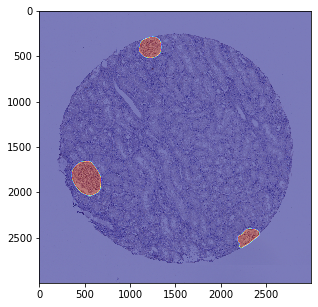

In [14]:
fn = np.random.choice(TRAIN_DF.fnames.values)
im = load_image_monai(fn)
mask = fn2mask(fn)
plot_image_mask(im, mask, figsize=(5, 5))

In [15]:
def alb_wrapper(arr, f):
    datatype = arr.dtype
    arr = torch.einsum("cwh->whc", arr) * 255.
    arr = f(image=arr.numpy().astype(np.uint8))["image"]
    arr = torch.Tensor(arr).to(datatype) / 255.
    return torch.einsum("whc->cwh", arr)
huesat = partial(alb_wrapper, f=A.HueSaturationValue(
    p=1, 
    hue_shift_limit=80,
    sat_shift_limit=80, 
    val_shift_limit=80, 
    always_apply=True))

In [16]:
def get_load_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        monai.transforms.Lambdad((IMAGE,), id2image),
        monai.transforms.TransposeD((IMAGE,), (2, 0, 1)),
        monai.transforms.Lambdad((LABEL,), id2mask),
        monai.transforms.AddChanneld((LABEL,)),
        monai.transforms.AsDiscreted((LABEL,), to_onehot=2),
        monai.transforms.ScaleIntensityD((IMAGE,)),
    ])

def get_train_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        *get_load_transforms().transforms,

        monai.transforms.CenterSpatialCropd(KEYS,roi_size=CROP_SIZE),
        
        monai.transforms.RandSpatialCropd(KEYS, roi_size=MIN_CROP_SIZE, max_roi_size=CROP_SIZE),
        monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
        monai.transforms.RandRotated(KEYS, range_x=3.14159, prob=1, padding_mode="reflection"),
        monai.transforms.Lambdad((IMAGE,), huesat),
        
        monai.transforms.RandAdjustContrastd((IMAGE,), prob=TRANSFORM_PROB),
        monai.transforms.RandGaussianNoised((IMAGE,), prob=TRANSFORM_PROB),
        monai.transforms.RandCoarseShuffled((IMAGE,), 
            holes=2, 
            max_holes=15, 
            spatial_size=(int(IMAGE_SIZE[0]*0.01), int(IMAGE_SIZE[1]*0.01)), 
            max_spatial_size=(int(IMAGE_SIZE[0]*0.1), int(IMAGE_SIZE[1]*0.1)),  
            prob=TRANSFORM_PROB),

        monai.transforms.AsDiscreteD((LABEL,), threshold=0.5),
        monai.transforms.EnsureTypeD(KEYS)
])

def get_valid_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        monai.transforms.Lambdad((IMAGE,), id2image),
        monai.transforms.TransposeD((IMAGE,), (2, 0, 1)),
        monai.transforms.Lambdad((LABEL,), id2mask),
        monai.transforms.AddChanneld((LABEL,)),
        monai.transforms.AsDiscreted((LABEL,), to_onehot=2),
        monai.transforms.ScaleIntensityD((IMAGE,)),
        monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
        monai.transforms.RandRotated(KEYS, range_x=3.14159, prob=1, padding_mode="reflection"),
        monai.transforms.AsDiscreteD((LABEL,), threshold=0.5),
        monai.transforms.EnsureTypeD(KEYS)
])

def get_test_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        monai.transforms.Lambdad((IMAGE,), id2image),
        monai.transforms.TransposeD((IMAGE,), (2, 0, 1)),
        monai.transforms.Lambdad((LABEL,), id2mask),
        monai.transforms.AddChanneld((LABEL,)),
        monai.transforms.AsDiscreted((LABEL,), to_onehot=2),
        monai.transforms.ScaleIntensityD((IMAGE,)),
        monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
        monai.transforms.EnsureTypeD(KEYS)
])

In [17]:
MOMENTUMS     = [0.9, 0.95, 0.99]
WEIGHT_DECAYS = [0.01, 0.001, 0.0001]

In [18]:
metrics_log = {"organ": [], "momentum": [], "weight_decay": [], "train_dice": [], "valid_dice": [], "test_dice": []}

HPS = list(itertools.product(TRAIN_DF.organ.unique(), MOMENTUMS, WEIGHT_DECAYS))

for organ, momentum, weight_decay in HPS:

    organ_train_test_df = split_df_train_test(TRAIN_DF[TRAIN_DF.organ==organ],"is_test", test_pct=0.1)
    organ_testset_df = organ_train_test_df[organ_train_test_df.is_test].copy()
    organ_train_valid_df = organ_train_test_df[~organ_train_test_df.is_test].copy()
    organ_train_valid_df = split_df_train_test(organ_train_valid_df, "is_valid", seed=92)
    assert len(organ_testset_df.organ.unique()) == 1
    assert len(organ_train_valid_df.organ.unique()) == 1
    del organ_train_test_df

    train_ids = organ_train_valid_df[~organ_train_valid_df.is_valid].id.values
    valid_ids = organ_train_valid_df[organ_train_valid_df.is_valid].id.values
    test_ids = organ_testset_df.id.values
    assert len(set(train_ids).intersection(set(valid_ids))) == 0
    assert len(set(train_ids).intersection(set(test_ids))) == 0
    assert len(set(valid_ids).intersection(set(test_ids))) == 0

    data_dicts = {
        "train": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(train_ids)},
        "valid": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(valid_ids)},
        "test":  {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(test_ids)}
    }

    train_ds = monai.data.CacheDataset(data_dicts["train"], transform=get_train_transforms())
    valid_ds = monai.data.CacheDataset(data_dicts["valid"], transform=get_valid_transforms())
    test_ds  = monai.data.CacheDataset(data_dicts["test"],  transform=get_test_transforms())

    train_dl = monai.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    valid_dl = monai.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_dl  = monai.data.DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    loaders = {"train": train_dl, "valid": valid_dl}

    model = smp.Unet(
        encoder_name=ENCODER,        
        encoder_weights="imagenet",     
        in_channels=3,                  
        classes=2,  
    )

    criterion = monai.losses.GeneralizedDiceFocalLoss(softmax=True)
    optimizer = Lookahead(torch.optim.RAdam(model.parameters(), lr=LR, betas=(momentum, 0.999), weight_decay=weight_decay))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

    dice_func = partial(
        calc_metric, 
        metric_func=monai.metrics.DiceMetric(include_background=False, reduction="mean"))

    callbacks = [
        catalyst.dl.FunctionalMetricCallback(
        input_key="logits",
        target_key=LABEL,
        metric_fn=dice_func,
        metric_key="dice"
        ),
        catalyst.dl.OptimizerCallback(
            metric_key="loss", 
            accumulation_steps=ACCUM_STEPS),
        catalyst.dl.EarlyStoppingCallback(
            patience=EARLY_STOP_PATIENCE, 
            loader_key="valid", 
            metric_key="loss",
            min_delta=1e-3,
            minimize=True)
    ]

    runner = catalyst.dl.SupervisedRunner(
        input_key=IMAGE, 
        output_key="logits", 
        target_key=LABEL, 
        loss_key="loss"
    )

    runner.train(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        loaders=loaders,
        num_epochs=EPOCHS,
        callbacks=callbacks,
        logdir=LOG_DIR/f"{organ}_mom{momentum}_wd{weight_decay}",
        valid_loader="valid",
        valid_metric="loss",
        minimize_valid_metric=True,
        verbose=False,
        timeit=False,
        load_best_on_end=True
    )

    dice_metric = monai.metrics.DiceMetric(
        include_background=False, 
        reduction="mean")

    train_dice = test_model(model, train_dl, metric_func=dice_metric)
    valid_dice = test_model(model, valid_dl, metric_func=dice_metric)
    test_dice = test_model(model, test_dl, metric_func=dice_metric)

    metrics_log["organ"].append(organ)
    metrics_log["momentum"].append(momentum)
    metrics_log["weight_decay"].append(weight_decay)
    metrics_log["train_dice"].append(train_dice)
    metrics_log["valid_dice"].append(valid_dice)
    metrics_log["test_dice"].append(test_dice)
    save_df(metrics_log, LOG_DIR/"metrics.csv", replace=True)

print("Done.")

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  5.05it/s]


train (1/200) dice: 0.3865989288863014 | dice/mean: 0.3865989288863014 | dice/std: 0.057999016080658494 | loss: 1.218551846111522 | loss/mean: 1.218551846111522 | loss/std: 0.06232823506806969 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.2698826193809509 | dice/mean: 0.2698826193809509 | dice/std: 0.010756645488467203 | loss: 1.0664430260658264 | loss/mean: 1.0664430260658264 | loss/std: 0.014360025694420343 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.3941052485914791 | dice/mean: 0.3941052485914791 | dice/std: 0.0998136578803741 | loss: 1.2298087582868689 | loss/mean: 1.2298087582868689 | loss/std: 0.10186483260384359 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.2748454213142395 | dice/mean: 0.2748454213142395 | dice/std: 0.010262384966154095 | loss: 1.0582556128501892 | loss/mean: 1.0582556128501892 | loss/std: 0.015565358989586695 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoch (2/

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  4.96it/s]


train (1/200) dice: 0.334040559390012 | dice/mean: 0.334040559390012 | dice/std: 0.06238227078655461 | loss: 0.9236883030218236 | loss/mean: 0.9236883030218236 | loss/std: 0.06829401660928008 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.25446493923664093 | dice/mean: 0.25446493923664093 | dice/std: 0.01125276818300599 | loss: 0.9317549765110016 | loss/mean: 0.9317549765110016 | loss/std: 0.014646184623050618 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.3255904509740718 | dice/mean: 0.3255904509740718 | dice/std: 0.08572588254829928 | loss: 0.9176701096927419 | loss/mean: 0.9176701096927419 | loss/std: 0.08178008727159412 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.194097101688385 | dice/mean: 0.194097101688385 | dice/std: 0.011589421219673048 | loss: 0.9128192663192749 | loss/mean: 0.9128192663192749 | loss/std: 0.011567013593552488 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoch (2/2

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  4.95it/s]


train (1/200) dice: 0.3650303325232337 | dice/mean: 0.3650303325232337 | dice/std: 0.11211408523272724 | loss: 1.0818906671860637 | loss/mean: 1.0818906671860637 | loss/std: 0.059789959403736735 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.2587987780570984 | dice/mean: 0.2587987780570984 | dice/std: 0.007746667238528163 | loss: 0.9656450748443604 | loss/mean: 0.9656450748443604 | loss/std: 0.010973334620182504 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.3434332363745745 | dice/mean: 0.3434332363745745 | dice/std: 0.10113497905887926 | loss: 1.0785477862638588 | loss/mean: 1.0785477862638588 | loss/std: 0.0852954975843419 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.26571352779865265 | dice/mean: 0.26571352779865265 | dice/std: 0.013889296257504444 | loss: 0.9869883358478546 | loss/mean: 0.9869883358478546 | loss/std: 0.017887903281041433 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoch

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  4.89it/s]


train (1/200) dice: 0.13343042880296707 | dice/mean: 0.13343042880296707 | dice/std: 0.017212779317777916 | loss: 0.8552898238686956 | loss/mean: 0.8552898238686956 | loss/std: 0.05702769150294208 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.13992847502231598 | dice/mean: 0.13992847502231598 | dice/std: 0.004596964512250827 | loss: 0.874384343624115 | loss/mean: 0.874384343624115 | loss/std: 0.015406781943195046 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.14093287639758165 | dice/mean: 0.14093287639758165 | dice/std: 0.017206509843616293 | loss: 0.8017969061346616 | loss/mean: 0.8017969061346616 | loss/std: 0.05424891407333067 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.1064431294798851 | dice/mean: 0.1064431294798851 | dice/std: 0.001839710735071928 | loss: 0.8614083826541901 | loss/mean: 0.8614083826541901 | loss/std: 0.0121511200782913 | lr: 0.00033919068644530263 | momentum: 0.95


Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  4.99it/s]


train (1/200) dice: 0.33403861347366776 | dice/mean: 0.33403861347366776 | dice/std: 0.062384735232388834 | loss: 0.923686097649967 | loss/mean: 0.923686097649967 | loss/std: 0.06829439823341973 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.2545231133699417 | dice/mean: 0.2545231133699417 | dice/std: 0.01121857192940717 | loss: 0.9318332672119141 | loss/mean: 0.9318332672119141 | loss/std: 0.014643506788610388 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.3256250427049749 | dice/mean: 0.3256250427049749 | dice/std: 0.08573530865200504 | loss: 0.9176548929775462 | loss/mean: 0.9176548929775462 | loss/std: 0.08179485094754332 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.1937287673354149 | dice/mean: 0.1937287673354149 | dice/std: 0.011651557751583596 | loss: 0.9129602313041687 | loss/mean: 0.9129602313041687 | loss/std: 0.011554886389305923 | lr: 0.00033919068644530263 | momentum: 0.95
* Ep

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  5.11it/s]


train (1/200) dice: 0.3650352218571831 | dice/mean: 0.3650352218571831 | dice/std: 0.11211648837949242 | loss: 1.081887392436757 | loss/mean: 1.081887392436757 | loss/std: 0.05979215618521242 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.25887663662433624 | dice/mean: 0.25887663662433624 | dice/std: 0.007748129274573117 | loss: 0.9658840000629425 | loss/mean: 0.9658840000629425 | loss/std: 0.010972811365176941 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.343445748090744 | dice/mean: 0.343445748090744 | dice/std: 0.10115575316906368 | loss: 1.078506722169764 | loss/mean: 1.078506722169764 | loss/std: 0.08531594794892487 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.26579129695892334 | dice/mean: 0.26579129695892334 | dice/std: 0.013890388937074883 | loss: 0.9865555763244629 | loss/mean: 0.9865555763244629 | loss/std: 0.017908864260970145 | lr: 0.00033919068644530263 | momentum: 0.95
* Epoc

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  4.98it/s]


train (1/200) dice: 0.33402198903700886 | dice/mean: 0.33402198903700886 | dice/std: 0.06240636881064775 | loss: 0.9236956168623531 | loss/mean: 0.9236956168623531 | loss/std: 0.06829921599194422 | lr: 0.000375 | momentum: 0.99
valid (1/200) dice: 0.2542891353368759 | dice/mean: 0.2542891353368759 | dice/std: 0.011246027427346096 | loss: 0.9319158494472504 | loss/mean: 0.9319158494472504 | loss/std: 0.014627409002262788 | lr: 0.000375 | momentum: 0.99
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.99
train (2/200) dice: 0.3252396899111131 | dice/mean: 0.3252396899111131 | dice/std: 0.08578907139900137 | loss: 0.9179778800291174 | loss/mean: 0.9179778800291174 | loss/std: 0.08182753155004469 | lr: 0.00033919068644530263 | momentum: 0.99
valid (2/200) dice: 0.19159115105867386 | dice/mean: 0.19159115105867386 | dice/std: 0.011131719293410345 | loss: 0.9134410619735718 | loss/mean: 0.9134410619735718 | loss/std: 0.011474305118449294 | lr: 0.00033919068644530263 | momentum: 0.99


Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  5.07it/s]


train (1/200) dice: 0.19500764327890732 | dice/mean: 0.19500764327890732 | dice/std: 0.05378881083314616 | loss: 0.837725043296814 | loss/mean: 0.837725043296814 | loss/std: 0.08013728464349877 | lr: 0.000375 | momentum: 0.99
valid (1/200) dice: 0.19682220369577408 | dice/mean: 0.19682220369577408 | dice/std: 0.0060404480892870946 | loss: 0.8777886927127838 | loss/mean: 0.8777886927127838 | loss/std: 0.017313923319645565 | lr: 0.000375 | momentum: 0.99
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.99
train (2/200) dice: 0.19913482315400066 | dice/mean: 0.19913482315400066 | dice/std: 0.037645472940769316 | loss: 0.8507633629967185 | loss/mean: 0.8507633629967185 | loss/std: 0.07219500529547634 | lr: 0.00033919068644530263 | momentum: 0.99
valid (2/200) dice: 0.20805300772190094 | dice/mean: 0.20805300772190094 | dice/std: 0.007664162236033439 | loss: 0.8674153387546539 | loss/mean: 0.8674153387546539 | loss/std: 0.01798584430620025 | lr: 0.00033919068644530263 | momentum: 0.

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  4.86it/s]


train (1/200) dice: 0.33403897460769205 | dice/mean: 0.33403897460769205 | dice/std: 0.062383813325019084 | loss: 0.9236805894795586 | loss/mean: 0.9236805894795586 | loss/std: 0.06829383107846292 | lr: 0.000375 | momentum: 0.99
valid (1/200) dice: 0.2547735869884491 | dice/mean: 0.2547735869884491 | dice/std: 0.011236347209743189 | loss: 0.9319782257080078 | loss/mean: 0.9319782257080078 | loss/std: 0.014648000625716983 | lr: 0.000375 | momentum: 0.99
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.99
train (2/200) dice: 0.32576145144069896 | dice/mean: 0.32576145144069896 | dice/std: 0.085706895295066 | loss: 0.9175447856678682 | loss/mean: 0.9175447856678682 | loss/std: 0.08180800944804624 | lr: 0.00033919068644530263 | momentum: 0.99
valid (2/200) dice: 0.1936963051557541 | dice/mean: 0.1936963051557541 | dice/std: 0.011748090605183326 | loss: 0.9132212102413177 | loss/mean: 0.9132212102413177 | loss/std: 0.01156273521438936 | lr: 0.00033919068644530263 | momentum: 0.99
* 

Loading dataset: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


train (1/200) dice: 0.24478487708629706 | dice/mean: 0.24478487708629706 | dice/std: 0.0743664412163705 | loss: 0.9699292274621817 | loss/mean: 0.9699292274621817 | loss/std: 0.07925841655172604 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.22981008804506725 | dice/mean: 0.22981008804506725 | dice/std: 0.06631037841240565 | loss: 1.037011808819241 | loss/mean: 1.037011808819241 | loss/std: 0.06950660546620686 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.21544786103260824 | dice/mean: 0.21544786103260824 | dice/std: 0.02994546408010048 | loss: 0.953335688664363 | loss/mean: 0.953335688664363 | loss/std: 0.07013219333316371 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.15431050356063578 | dice/mean: 0.15431050356063578 | dice/std: 0.048318538193901375 | loss: 0.9820415708753798 | loss/mean: 0.9820415708753798 | loss/std: 0.06956390539805093 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoch (

Loading dataset: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


train (1/200) dice: 0.24478625869139647 | dice/mean: 0.24478625869139647 | dice/std: 0.07437473685182963 | loss: 0.9699321221082639 | loss/mean: 0.9699321221082639 | loss/std: 0.07925714457348372 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.22982050023145145 | dice/mean: 0.22982050023145145 | dice/std: 0.06631490464011829 | loss: 1.0370345380571153 | loss/mean: 1.0370345380571153 | loss/std: 0.0695021947224935 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.21553878944653732 | dice/mean: 0.21553878944653732 | dice/std: 0.030010551875665595 | loss: 0.9532830776312412 | loss/mean: 0.9532830776312412 | loss/std: 0.07014699197127448 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.1545430806775888 | dice/mean: 0.1545430806775888 | dice/std: 0.048411522060632706 | loss: 0.9820191860198975 | loss/mean: 0.9820191860198975 | loss/std: 0.06957650184631348 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoc

Loading dataset: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


train (1/200) dice: 0.3097204802892147 | dice/mean: 0.3097204802892147 | dice/std: 0.07704761809458298 | loss: 1.295220747972146 | loss/mean: 1.295220747972146 | loss/std: 0.08235565518538081 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.2567645249267419 | dice/mean: 0.2567645249267419 | dice/std: 0.07433940842747688 | loss: 1.0910151534610324 | loss/mean: 1.0910151534610324 | loss/std: 0.06463996569315593 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.2422276666531196 | dice/mean: 0.2422276666531196 | dice/std: 0.055856202523027955 | loss: 1.3545969143891945 | loss/mean: 1.3545969143891945 | loss/std: 0.05712854442570616 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.22827021529277167 | dice/mean: 0.22827021529277167 | dice/std: 0.069759301841259 | loss: 1.009919868575202 | loss/mean: 1.009919868575202 | loss/std: 0.07207628091176353 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoch (2/200) 

Loading dataset: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


train (1/200) dice: 0.24478058555187324 | dice/mean: 0.24478058555187324 | dice/std: 0.07436645381952207 | loss: 0.9699268891261175 | loss/mean: 0.9699268891261175 | loss/std: 0.07925929912994936 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.22980835123194587 | dice/mean: 0.22980835123194587 | dice/std: 0.06630879392226537 | loss: 1.036996841430664 | loss/mean: 1.036996841430664 | loss/std: 0.06950533390045166 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.2154520238057161 | dice/mean: 0.2154520238057161 | dice/std: 0.029947908412800928 | loss: 0.9533314490929627 | loss/mean: 0.9533314490929627 | loss/std: 0.07013373157957893 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.15433140968283018 | dice/mean: 0.15433140968283018 | dice/std: 0.04832823947072029 | loss: 0.9820610947079129 | loss/mean: 0.9820610947079129 | loss/std: 0.0695663293202718 | lr: 0.00033919068644530263 | momentum: 0.95
* Ep

Loading dataset: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


train (1/200) dice: 0.24478049385241973 | dice/mean: 0.24478049385241973 | dice/std: 0.07437093645309176 | loss: 0.9699297623756604 | loss/mean: 0.9699297623756604 | loss/std: 0.07925809296538304 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.22980673528379864 | dice/mean: 0.22980673528379864 | dice/std: 0.06630818794171016 | loss: 1.0370213985443115 | loss/mean: 1.0370213985443115 | loss/std: 0.06950139999389648 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.21552912088540885 | dice/mean: 0.21552912088540885 | dice/std: 0.030003674914570986 | loss: 0.9532798375838842 | loss/mean: 0.9532798375838842 | loss/std: 0.07014886592458897 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.15451909808648956 | dice/mean: 0.15451909808648956 | dice/std: 0.04840327178438504 | loss: 0.9820462465286255 | loss/mean: 0.9820462465286255 | loss/std: 0.069580078125 | lr: 0.00033919068644530263 | momentum: 0.95
* Ep

Loading dataset: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


train (1/200) dice: 0.30972116039349484 | dice/mean: 0.30972116039349484 | dice/std: 0.07704720963180933 | loss: 1.2952165725903633 | loss/mean: 1.2952165725903633 | loss/std: 0.08235760768189711 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.256775404430098 | dice/mean: 0.256775404430098 | dice/std: 0.07434163863460223 | loss: 1.0909895102183025 | loss/mean: 1.0909895102183025 | loss/std: 0.06463921070098876 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.24223379294077554 | dice/mean: 0.24223379294077554 | dice/std: 0.05585383912679249 | loss: 1.3545818084325545 | loss/mean: 1.3545818084325545 | loss/std: 0.05713939011705575 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.2282323328157266 | dice/mean: 0.2282323328157266 | dice/std: 0.06974724307656288 | loss: 1.009934663772583 | loss/mean: 1.009934663772583 | loss/std: 0.07207220792770386 | lr: 0.00033919068644530263 | momentum: 0.95
* Epoch 

Loading dataset: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


train (1/200) dice: 0.2613796033920386 | dice/mean: 0.2613796033920386 | dice/std: 0.0731485105401094 | loss: 1.0836459703934498 | loss/mean: 1.0836459703934498 | loss/std: 0.07809197476734157 | lr: 0.000375 | momentum: 0.99
valid (1/200) dice: 0.1273332681092951 | dice/mean: 0.1273332681092951 | dice/std: 0.024469391753276188 | loss: 0.9584225416183472 | loss/mean: 0.9584225416183472 | loss/std: 0.05687624216079712 | lr: 0.000375 | momentum: 0.99
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.99
train (2/200) dice: 0.269279135343356 | dice/mean: 0.269279135343356 | dice/std: 0.04178793703508645 | loss: 1.1128323047589033 | loss/mean: 1.1128323047589033 | loss/std: 0.0639827460041173 | lr: 0.00033919068644530263 | momentum: 0.99
valid (2/200) dice: 0.22001340405808556 | dice/mean: 0.22001340405808556 | dice/std: 0.05668564389149348 | loss: 0.9596498409907023 | loss/mean: 0.9596498409907023 | loss/std: 0.06495356559753418 | lr: 0.00033919068644530263 | momentum: 0.99
* Epoch (

Loading dataset: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]


train (1/200) dice: 0.2613701461217342 | dice/mean: 0.2613701461217342 | dice/std: 0.07314029539800009 | loss: 1.0836510902796037 | loss/mean: 1.0836510902796037 | loss/std: 0.07809341694582023 | lr: 0.000375 | momentum: 0.99
valid (1/200) dice: 0.12735907857616743 | dice/mean: 0.12735907857616743 | dice/std: 0.024481903761625293 | loss: 0.9584302372402616 | loss/mean: 0.9584302372402616 | loss/std: 0.05687858661015827 | lr: 0.000375 | momentum: 0.99
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.99
train (2/200) dice: 0.26928254809135044 | dice/mean: 0.26928254809135044 | dice/std: 0.04178538652037019 | loss: 1.1127787706179497 | loss/mean: 1.1127787706179497 | loss/std: 0.06402378113039783 | lr: 0.00033919068644530263 | momentum: 0.99
valid (2/200) dice: 0.21947422044144738 | dice/mean: 0.21947422044144738 | dice/std: 0.05664979169766108 | loss: 0.9598662190967135 | loss/mean: 0.9598662190967135 | loss/std: 0.06495289007822673 | lr: 0.00033919068644530263 | momentum: 0.99
*

Loading dataset: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s]


train (1/200) dice: 0.1998944572913341 | dice/mean: 0.1998944572913341 | dice/std: 0.05049399785644704 | loss: 0.9988215137750674 | loss/mean: 0.9988215137750674 | loss/std: 0.07060768403624644 | lr: 0.000375 | momentum: 0.99
valid (1/200) dice: 0.22831342783239153 | dice/mean: 0.22831342783239153 | dice/std: 0.06893845895926158 | loss: 1.0712595250871446 | loss/mean: 1.0712595250871446 | loss/std: 0.06849833329518637 | lr: 0.000375 | momentum: 0.99
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.99
train (2/200) dice: 0.2113813750254802 | dice/mean: 0.2113813750254802 | dice/std: 0.03823498973574765 | loss: 0.9422148863474528 | loss/mean: 0.9422148863474528 | loss/std: 0.05235686952887259 | lr: 0.00033919068644530263 | momentum: 0.99
valid (2/200) dice: 0.22014636463589138 | dice/mean: 0.22014636463589138 | dice/std: 0.06341741482416789 | loss: 0.9931575854619344 | loss/mean: 0.9931575854619344 | loss/std: 0.0609067678451538 | lr: 0.00033919068644530263 | momentum: 0.99
* Epo

Loading dataset: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


train (1/200) dice: 0.08230711271365483 | dice/mean: 0.08230711271365483 | dice/std: 0.019654793668623226 | loss: 1.100200679567125 | loss/mean: 1.100200679567125 | loss/std: 0.051674337086214474 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.04567233473062515 | dice/mean: 0.04567233473062515 | dice/std: 0.0 | loss: 1.2375011444091797 | loss/mean: 1.2375011444091797 | loss/std: 0.0 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.0984949308137099 | dice/mean: 0.0984949308137099 | dice/std: 0.05446519052119748 | loss: 1.047864768240187 | loss/mean: 1.047864768240187 | loss/std: 0.08252044752774051 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.04733607918024063 | dice/mean: 0.04733607918024063 | dice/std: 0.0 | loss: 1.1774333715438843 | loss/mean: 1.1774333715438843 | loss/std: 0.0 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoch (2/200) lr: 0.00024544068644530265 | momentum: 0.9
train (3/200) 

Loading dataset: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


train (1/200) dice: 0.08230051232708825 | dice/mean: 0.08230051232708825 | dice/std: 0.019665031048073288 | loss: 1.100203726026747 | loss/mean: 1.100203726026747 | loss/std: 0.05167425906428778 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.045668940991163254 | dice/mean: 0.045668940991163254 | dice/std: 0.0 | loss: 1.2375614643096924 | loss/mean: 1.2375614643096924 | loss/std: 0.0 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.09851045037309329 | dice/mean: 0.09851045037309329 | dice/std: 0.054480003754331464 | loss: 1.047821905877855 | loss/mean: 1.047821905877855 | loss/std: 0.0825474744758402 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.04740683734416962 | dice/mean: 0.04740683734416962 | dice/std: 0.0 | loss: 1.177389144897461 | loss/mean: 1.177389144897461 | loss/std: 0.0 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoch (2/200) lr: 0.00024544068644530265 | momentum: 0.9
train (3/200)

Loading dataset: 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


train (1/200) dice: 0.08230644795629713 | dice/mean: 0.08230644795629713 | dice/std: 0.01965892783189221 | loss: 1.100203858481513 | loss/mean: 1.100203858481513 | loss/std: 0.051674134030289295 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.045664384961128235 | dice/mean: 0.045664384961128235 | dice/std: 0.0 | loss: 1.237562894821167 | loss/mean: 1.237562894821167 | loss/std: 0.0 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.09853805229067802 | dice/mean: 0.09853805229067802 | dice/std: 0.054490133407430384 | loss: 1.047814130783081 | loss/mean: 1.047814130783081 | loss/std: 0.0825549719551178 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.047429800033569336 | dice/mean: 0.047429800033569336 | dice/std: 0.0 | loss: 1.1774799823760986 | loss/mean: 1.1774799823760986 | loss/std: 0.0 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoch (2/200) lr: 0.00024544068644530265 | momentum: 0.9
train (3/20

Loading dataset: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


train (1/200) dice: 0.08230457951625188 | dice/mean: 0.08230457951625188 | dice/std: 0.01965672439508605 | loss: 1.100198785463969 | loss/mean: 1.100198785463969 | loss/std: 0.05167432224741766 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.045665524899959564 | dice/mean: 0.045665524899959564 | dice/std: 0.0 | loss: 1.2374913692474365 | loss/mean: 1.2374913692474365 | loss/std: 0.0 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.09849628392193052 | dice/mean: 0.09849628392193052 | dice/std: 0.054457053580463245 | loss: 1.0478560262256198 | loss/mean: 1.0478560262256198 | loss/std: 0.08252335976509215 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.04733831435441971 | dice/mean: 0.04733831435441971 | dice/std: 0.0 | loss: 1.1773711442947388 | loss/mean: 1.1773711442947388 | loss/std: 0.0 | lr: 0.00033919068644530263 | momentum: 0.95
* Epoch (2/200) lr: 0.00024544068644530265 | momentum: 0.95
tra

Loading dataset: 100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


train (1/200) dice: 0.08230369538068771 | dice/mean: 0.08230369538068771 | dice/std: 0.01966489268764313 | loss: 1.1002018716600206 | loss/mean: 1.1002018716600206 | loss/std: 0.051674248137653325 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.04566151648759842 | dice/mean: 0.04566151648759842 | dice/std: 0.0 | loss: 1.237547516822815 | loss/mean: 1.237547516822815 | loss/std: 0.0 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.09849967352218097 | dice/mean: 0.09849967352218097 | dice/std: 0.054473172135452025 | loss: 1.0478124883439806 | loss/mean: 1.0478124883439806 | loss/std: 0.08255152724006261 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.04740004613995552 | dice/mean: 0.04740004613995552 | dice/std: 0.0 | loss: 1.1773231029510498 | loss/mean: 1.1773231029510498 | loss/std: 0.0 | lr: 0.00033919068644530263 | momentum: 0.95
* Epoch (2/200) lr: 0.00024544068644530265 | momentum: 0.95
trai

Loading dataset: 100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


train (1/200) dice: 0.08230874356296328 | dice/mean: 0.08230874356296328 | dice/std: 0.019659189100493284 | loss: 1.1002019776238336 | loss/mean: 1.1002019776238336 | loss/std: 0.051674134575027196 | lr: 0.000375 | momentum: 0.95
valid (1/200) dice: 0.04566527158021927 | dice/mean: 0.04566527158021927 | dice/std: 0.0 | loss: 1.2375538349151611 | loss/mean: 1.2375538349151611 | loss/std: 0.0 | lr: 0.000375 | momentum: 0.95
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.95
train (2/200) dice: 0.09853198958767785 | dice/mean: 0.09853198958767785 | dice/std: 0.05447404414607774 | loss: 1.047804872194926 | loss/mean: 1.047804872194926 | loss/std: 0.08255925002068293 | lr: 0.00033919068644530263 | momentum: 0.95
valid (2/200) dice: 0.04743338003754616 | dice/mean: 0.04743338003754616 | dice/std: 0.0 | loss: 1.1774159669876099 | loss/mean: 1.1774159669876099 | loss/std: 0.0 | lr: 0.00033919068644530263 | momentum: 0.95
* Epoch (2/200) lr: 0.00024544068644530265 | momentum: 0.95
trai

Loading dataset: 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


train (1/200) dice: 0.0823063916630215 | dice/mean: 0.0823063916630215 | dice/std: 0.01965527287926049 | loss: 1.1001976595984564 | loss/mean: 1.1001976595984564 | loss/std: 0.051674124758083195 | lr: 0.000375 | momentum: 0.99
valid (1/200) dice: 0.04566200077533722 | dice/mean: 0.04566200077533722 | dice/std: 0.0 | loss: 1.2374823093414307 | loss/mean: 1.2374823093414307 | loss/std: 0.0 | lr: 0.000375 | momentum: 0.99
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.99
train (2/200) dice: 0.09848840162158012 | dice/mean: 0.09848840162158012 | dice/std: 0.05445955738387517 | loss: 1.0478494962056477 | loss/mean: 1.0478494962056477 | loss/std: 0.08252563955126814 | lr: 0.00033919068644530263 | momentum: 0.99
valid (2/200) dice: 0.04734095558524132 | dice/mean: 0.04734095558524132 | dice/std: 0.0 | loss: 1.1773104667663574 | loss/mean: 1.1773104667663574 | loss/std: 0.0 | lr: 0.00033919068644530263 | momentum: 0.99
* Epoch (2/200) lr: 0.00024544068644530265 | momentum: 0.99
train

Loading dataset: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


train (1/200) dice: 0.0823056838578648 | dice/mean: 0.0823056838578648 | dice/std: 0.019655390445280745 | loss: 1.100200547112359 | loss/mean: 1.100200547112359 | loss/std: 0.051674202320995295 | lr: 0.000375 | momentum: 0.99
valid (1/200) dice: 0.04566538706421852 | dice/mean: 0.04566538706421852 | dice/std: 0.0 | loss: 1.2375409603118896 | loss/mean: 1.2375409603118896 | loss/std: 0.0 | lr: 0.000375 | momentum: 0.99
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.99
train (2/200) dice: 0.09850294432706302 | dice/mean: 0.09850294432706302 | dice/std: 0.054472219874703326 | loss: 1.0478054152594671 | loss/mean: 1.0478054152594671 | loss/std: 0.08255500315144007 | lr: 0.00033919068644530263 | momentum: 0.99
valid (2/200) dice: 0.047407329082489014 | dice/mean: 0.047407329082489014 | dice/std: 0.0 | loss: 1.1772639751434326 | loss/mean: 1.1772639751434326 | loss/std: 0.0 | lr: 0.00033919068644530263 | momentum: 0.99
* Epoch (2/200) lr: 0.00024544068644530265 | momentum: 0.99
tra

Loading dataset: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


train (1/200) dice: 0.08230298136671384 | dice/mean: 0.08230298136671384 | dice/std: 0.019660087128968714 | loss: 1.100200679567125 | loss/mean: 1.100200679567125 | loss/std: 0.051674027604420636 | lr: 0.000375 | momentum: 0.99
valid (1/200) dice: 0.045665159821510315 | dice/mean: 0.045665159821510315 | dice/std: 0.0 | loss: 1.2375473976135254 | loss/mean: 1.2375473976135254 | loss/std: 0.0 | lr: 0.000375 | momentum: 0.99
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.99
train (2/200) dice: 0.09853127888507313 | dice/mean: 0.09853127888507313 | dice/std: 0.05447340518721038 | loss: 1.0477972825368245 | loss/mean: 1.0477972825368245 | loss/std: 0.08256448387557355 | lr: 0.00033919068644530263 | momentum: 0.99
valid (2/200) dice: 0.047425009310245514 | dice/mean: 0.047425009310245514 | dice/std: 0.0 | loss: 1.177342176437378 | loss/mean: 1.177342176437378 | loss/std: 0.0 | lr: 0.00033919068644530263 | momentum: 0.99
* Epoch (2/200) lr: 0.00024544068644530265 | momentum: 0.99
tr

Loading dataset: 100%|██████████| 9/9 [00:02<00:00,  4.42it/s]


train (1/200) dice: 0.1271698930197292 | dice/mean: 0.1271698930197292 | dice/std: 0.036094590812685054 | loss: 1.0642356607649062 | loss/mean: 1.0642356607649062 | loss/std: 0.05368009149626543 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.056599813203016915 | dice/mean: 0.056599813203016915 | dice/std: 0.009144056922501009 | loss: 1.154742267396715 | loss/mean: 1.154742267396715 | loss/std: 0.009813293580695517 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.10545074525806637 | dice/mean: 0.10545074525806637 | dice/std: 0.016217287801730002 | loss: 1.0625645253393388 | loss/mean: 1.0625645253393388 | loss/std: 0.10053500953556811 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.04855645861890581 | dice/mean: 0.04855645861890581 | dice/std: 0.011067654778695585 | loss: 1.1208241250779893 | loss/mean: 1.1208241250779893 | loss/std: 0.0126229298212932 | lr: 0.00033919068644530263 | momentum: 0.9
* E

Loading dataset: 100%|██████████| 9/9 [00:02<00:00,  4.47it/s]


train (1/200) dice: 0.11778021769391164 | dice/mean: 0.11778021769391164 | dice/std: 0.03758284603906358 | loss: 0.9935355583826699 | loss/mean: 0.9935355583826699 | loss/std: 0.07500705874810529 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.06365757435560226 | dice/mean: 0.06365757435560226 | dice/std: 0.0065770175801434065 | loss: 1.1870796150631375 | loss/mean: 1.1870796150631375 | loss/std: 0.008531917531250504 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.13108822372224596 | dice/mean: 0.13108822372224596 | dice/std: 0.028121893867326605 | loss: 1.0298870470788744 | loss/mean: 1.0298870470788744 | loss/std: 0.10437665793180871 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.06858343051539527 | dice/mean: 0.06858343051539527 | dice/std: 0.013909466658179243 | loss: 1.0552153322431777 | loss/mean: 1.0552153322431777 | loss/std: 0.01024112708185309 | lr: 0.00033919068644530263 | momentum: 0.9


Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  5.17it/s]


train (1/200) dice: 0.13036157108015484 | dice/mean: 0.13036157108015484 | dice/std: 0.017304979187326302 | loss: 0.9880350165896945 | loss/mean: 0.9880350165896945 | loss/std: 0.04787781916155276 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.05090904649760988 | dice/mean: 0.05090904649760988 | dice/std: 0.011881165036596784 | loss: 1.0901054408815172 | loss/mean: 1.0901054408815172 | loss/std: 0.011215102449614173 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.1209216747019026 | dice/mean: 0.1209216747019026 | dice/std: 0.03789528984462617 | loss: 0.9853227602110969 | loss/mean: 0.9853227602110969 | loss/std: 0.06880422377973598 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.07183007730378045 | dice/mean: 0.07183007730378045 | dice/std: 0.013766088982423125 | loss: 1.0815517637464735 | loss/mean: 1.0815517637464735 | loss/std: 0.011977107491695917 | lr: 0.00033919068644530263 | momentum: 0.9
* 

## End of submission model training

In [ ]:
test_dice

In [ ]:
plot_results(model, test_dl, figsize=25, threshold=0.5)

In [ ]:
d = one_batch(test_dl)

In [ ]:
d[IMAGE].shape

In [ ]:
organ = "kidney"

organ_train_test_df = split_df_train_test(TRAIN_DF[TRAIN_DF.organ==organ],"is_test", test_pct=0.1)
organ_testset_df = organ_train_test_df[organ_train_test_df.is_test].copy()
organ_train_valid_df = organ_train_test_df[~organ_train_test_df.is_test].copy()
organ_train_valid_df = split_df_train_test(organ_train_valid_df, "is_valid", seed=92)
assert len(organ_testset_df.organ.unique()) == 1
assert len(organ_train_valid_df.organ.unique()) == 1
del organ_train_test_df

train_ids = organ_train_valid_df[~organ_train_valid_df.is_valid].id.values
valid_ids = organ_train_valid_df[organ_train_valid_df.is_valid].id.values
test_ids = organ_testset_df.id.values
assert len(set(train_ids).intersection(set(valid_ids))) == 0
assert len(set(train_ids).intersection(set(test_ids))) == 0
assert len(set(valid_ids).intersection(set(test_ids))) == 0

data_dicts = {
    "train": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(train_ids)},
    "valid": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(valid_ids)},
    "test":  {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(test_ids)}
}

train_ds = monai.data.Dataset(data_dicts["train"], transform=get_train_transforms())
valid_ds = monai.data.Dataset(data_dicts["valid"], transform=get_valid_transforms())
test_ds  = monai.data.Dataset(data_dicts["test"],  transform=get_test_transforms())

train_dl = monai.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = monai.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl  = monai.data.DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = load_weights(
    model, 
    f"/home/favi/work/kaggle/hubmap_reboot/logs/{EXP_NAME}/{organ}/checkpoints/model.0191.pth")
test_model(
    model, 
    test_dl, 
    metric_func=dice_metric, threshold=0.5)

In [ ]:
plot_results(model, test_dl, threshold=0.5)

In [ ]:
#monai.transforms.Lambdad((IMAGE,), id2image)

In [ ]:
def get_train_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
    *get_load_transforms().transforms,

    monai.transforms.CenterSpatialCropd(KEYS,roi_size=CROP_SIZE),
    monai.transforms.RandRotated(KEYS, range_x=3.14159, prob=TRANSFORM_PROB),
    monai.transforms.RandSpatialCropd(KEYS, roi_size=MIN_CROP_SIZE, max_roi_size=CROP_SIZE),
    monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
    monai.transforms.Lambdad((IMAGE,), huesat),
    
    monai.transforms.RandAdjustContrastd((IMAGE,), prob=TRANSFORM_PROB),
    monai.transforms.RandGaussianNoised((IMAGE,), prob=TRANSFORM_PROB),
    monai.transforms.RandCoarseShuffled((IMAGE,), 
        holes=2, 
        max_holes=15, 
        spatial_size=(int(IMAGE_SIZE[0]*0.01), int(IMAGE_SIZE[1]*0.01)), 
        max_spatial_size=(int(IMAGE_SIZE[0]*0.1), int(IMAGE_SIZE[1]*0.1)),  
        prob=TRANSFORM_PROB),

    monai.transforms.AsDiscreteD((LABEL,), threshold=0.5),
    monai.transforms.EnsureTypeD(KEYS)
])

In [ ]:
organ = "prostate"

In [ ]:
organ_train_test_df = split_df_train_test(TRAIN_DF[TRAIN_DF.organ==organ],"is_test", test_pct=0.1)
organ_testset_df = organ_train_test_df[organ_train_test_df.is_test].copy()
organ_train_valid_df = organ_train_test_df[~organ_train_test_df.is_test].copy()
organ_train_valid_df = split_df_train_test(organ_train_valid_df, "is_valid", seed=92)
assert len(organ_testset_df.organ.unique()) == 1
assert len(organ_train_valid_df.organ.unique()) == 1
del organ_train_test_df

In [ ]:
train_ids = organ_train_valid_df[~organ_train_valid_df.is_valid].id.values
valid_ids = organ_train_valid_df[organ_train_valid_df.is_valid].id.values
test_ids = organ_testset_df.id.values
assert len(set(train_ids).intersection(set(valid_ids))) == 0
assert len(set(train_ids).intersection(set(test_ids))) == 0
assert len(set(valid_ids).intersection(set(test_ids))) == 0

data_dicts = {
    "train": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(train_ids)},
    "valid": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(valid_ids)},
    "test":  {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(test_ids)}
}

In [ ]:
train_ds = monai.data.Dataset(data_dicts["train"], transform=get_train_transforms())
valid_ds = monai.data.Dataset(data_dicts["valid"], transform=get_valid_transforms())
test_ds  = monai.data.Dataset(data_dicts["test"],  transform=get_valid_transforms())

train_dl = monai.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = monai.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl  = monai.data.DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

loaders = {"train": train_dl, "valid": valid_dl}

In [ ]:
plot_batch(one_batch(train_dl,b_idx=0))

In [ ]:
d = next(iter(train_dl))
msk = d[LABEL]

In [ ]:
criterion = monai.losses.GeneralizedDiceFocalLoss(softmax=True)
optimizer = Lookahead(torch.optim.RAdam(model.parameters(), lr=LR))
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

In [ ]:
def calc_metric(
        y_hat:torch.Tensor,
        y:torch.Tensor,
        metric_func:callable,
        process_logits:callable=monai.transforms.Compose([
                monai.transforms.EnsureType(), 
                monai.transforms.Activations(softmax=True),
                monai.transforms.AsDiscrete(argmax=True)
            ])) -> float:
    y_hat = [process_logits(i) for i in monai.data.decollate_batch(y_hat)]
    y = [i for i in monai.data.decollate_batch(y)]
    metric = metric_func(y_hat, y)
    metric = metric_func.aggregate().item()
    metric_func.reset()
    return metric

dice_func = partial(
    calc_metric, 
    metric_func=monai.metrics.DiceMetric(include_background=False, reduction="mean"))

In [ ]:
callbacks = [
    catalyst.dl.FunctionalMetricCallback(
    input_key="logits",
    target_key=LABEL,
    metric_fn=dice_func,
    metric_key="dice"
    ),
    catalyst.dl.OptimizerCallback(
        metric_key="loss", 
        accumulation_steps=ACCUM_STEPS),
    catalyst.dl.EarlyStoppingCallback(
        patience=EARLY_STOP_PATIENCE, 
        loader_key="valid", 
        metric_key="loss",
        min_delta=1e-3,
        minimize=True)
]

In [ ]:
runner = catalyst.dl.SupervisedRunner(
    input_key=IMAGE, 
    output_key="logits", 
    target_key=LABEL, 
    loss_key="loss"
)

In [ ]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    num_epochs=EPOCHS,
    callbacks=callbacks,
    logdir=LOG_DIR/organ,
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=False,
    timeit=False,
    load_best_on_end=True
)

In [ ]:
test_model(model, test_dl, monai.metrics.DiceMetric(
    include_background=False, 
    reduction="mean"),
    threshold=0.5)

In [ ]:
plot_results(model, test_dl, figsize=10)